# 기계학습특론 Final Project 10조 - 개별 구현
## 2024712428 인공지능융합학과 노희섭
#### MambaTab (supervised learning) for classification of adult dataset with fairness evaluation

In [34]:
# I used python kernel 3.10.15 + nvidia RTX 3090 + cuda 12.1 in local machine

# install ralated modules
%pip install torch==2.1.1 torchvision==0.16.1   # compatible version of pytorch and torchvision for mamba-ssm 
%pip install causal-conv1d==1.1.1   # causal dpthwise conv 1d  module in CUDA with pytorch
%pip install mamba-ssm  # Mamba block module

Note: you may need to restart the kernel to use updated packages.
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [35]:
# import modules

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary

from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import tqdm

from mamba_ssm import Mamba

import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
import matplotlib.pyplot as plt

import copy
from collections import defaultdict

In [36]:
# Check environments

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
torch.cuda.is_available()

torch:  2.1 ; cuda:  cu121


True

In [37]:
# Get original data from UCI

!mkdir ./datasets
!mkdir ./datasets/adult
!wget -nc https://archive.ics.uci.edu/static/public/2/adult.zip
!unzip -o ./adult.zip -d ./datasets/adult
!cp -rf ./datasets/adult/adult.data ./datasets/adult/data_processed.csv

mkdir: `./datasets' 디렉터리를 만들 수 없습니다: 파일이 있습니다
mkdir: `./datasets/adult' 디렉터리를 만들 수 없습니다: 파일이 있습니다
‘adult.zip’ 파일이 이미 있습니다. 가져오지 않음.

Archive:  ./adult.zip
  inflating: ./datasets/adult/Index  
  inflating: ./datasets/adult/adult.data  
  inflating: ./datasets/adult/adult.names  
  inflating: ./datasets/adult/adult.test  
  inflating: ./datasets/adult/old.adult.names  


In [38]:
# Set Configuration for MambaTab
config={
    'DATASET_NAME':'adult',
    'SEED':15, # random seed 지정
    'BATCH':100,
    'LR':0.0001,
    'EPOCH':1000,
    'MAMBA_SSM_DIM':32,  # MAMBA model의 dimension 설정 (d_model: Selective Structured State Machine에 담을 최대 Dimension)
    'device':'cuda'}

In [40]:
# data load and preparing

def read_data(dataset_name):
    data=pd.read_csv('./datasets/'+dataset_name+'/data_processed'+'.csv')
    
    # fill null values
    for col in data.columns: 
        #data[col].fillna(data[col].mode()[0], inplace=True)
        data[col] = data[col].fillna(data[col].mode()[0])

    # categorical encoder: 문자열인 경우 소문자로 통일하고, 숫자로 인코딩 처리
    for c in data.columns:
        if is_string_dtype(data[c]):
            data[c]=data[c].str.lower()
            enc=OrdinalEncoder()
            cur_data=np.array(data[c])
            cur_data=np.reshape(cur_data,(cur_data.shape[0],1))
            data[c] = enc.fit_transform(cur_data)

    # 마지막 column을 lable로 추출
    y_data=data[data.columns[-1]]

    # 9번째 컬럼(gender)을 공정성 지표 계산을 위해 별도로 추출
    sensitive_data=data[data.columns[9]]

    # label 컬럼 제거
    x_data = data.drop(labels = [data.columns[-1]],axis = 1)
    
    # 나머지 컬럼 스케일링 처리
    x_data=MinMaxScaler().fit_transform(x_data)
    
    x_data, y_data, sensitive_data = np.array(x_data),np.array(y_data), np.array(sensitive_data)
    
    return x_data, y_data, sensitive_data

In [ ]:
# check sensitive column (gendar)

d = pd.read_csv('./datasets/adult/data_processed.csv')
d[d.columns[9]]

0           Male
1           Male
2           Male
3         Female
4         Female
          ...   
32555     Female
32556       Male
32557     Female
32558       Male
32559     Female
Name:  Male, Length: 32560, dtype: object

In [ ]:
# MambaTab Class

class MambaTab(torch.nn.Module):

    def __init__(self,input_features, n_class, intermediate_representation=config['MAMBA_SSM_DIM']):
        super(MambaTab, self).__init__()
        self.linear_layer=torch.nn.Linear(input_features,intermediate_representation)
        self.relu=torch.nn.ReLU()
        self.layer_norm=torch.nn.LayerNorm(intermediate_representation)

        self.mamba=Mamba(d_model=intermediate_representation, d_state=32, d_conv=4, expand=2) # to fine-tuning
        self.output_layer=torch.nn.Linear(intermediate_representation,n_class)
    
    # 논문의 deault model 참조해서 building
    def forward(self, x):
         x=self.linear_layer(x)
         x=self.layer_norm(x)
         x=self.relu(x)
         x=self.mamba(x)
         x=self.output_layer(x)
         return x

In [50]:
# Training function

def train_model(model, config, dataloader):
    best_model_wts = copy.deepcopy(model.state_dict()) # 최적 가중치 저장
    best_loss = 1e10 # 최적 손실값 초기화
    early_stopping_counter=0 # earlt stopping 값 초기화

    optimizer=torch.optim.Adam(model.parameters(),lr=config['LR'])  # Optimizer setting: Adam
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['EPOCH'], eta_min=0,verbose=False) # learning rate 감소를 위한 scheduler setting
    loss_fn=torch.nn.BCEWithLogitsLoss()    # 이진분류 처리를 위해 BCEWithLogitLoss 함수 사용
  
    # 학습 진행
    for epoch in tqdm.tqdm(range(config['EPOCH'])):
        if early_stopping_counter>=5:
          break
        
        for phase in ['train', 'val']:      
            if phase == 'train':               
                model.train()  
            else:
                model.eval()  
            
            metrics = defaultdict(float)
            epoch_samples = 0
          
            for btch,feed_dict in enumerate(dataloader[phase]):
                inputs=feed_dict[0]
                inputs=inputs.unsqueeze(0)
                labels=feed_dict[1]
                sensitives=feed_dict[2]
                
                inputs = inputs.type(torch.FloatTensor)
                inputs = inputs.to(config['device'])
                labels = labels.type(torch.FloatTensor)
                labels = labels.to(config['device'])
                # sensitives = sensitives.type(torch.FloatTensor)
                # sensitives = sensitives.to(config['device'])

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'): # 학습 단계에서만 gradient 계산

                    outputs = model(inputs)  # 모델 학습
                    outputs=outputs.squeeze()  
                    loss=loss_fn(outputs,labels) # 손실 계산
                    metrics['loss']+=loss.item()
                
                    if phase == 'train':
                        loss.backward() # gradient 계산
                        optimizer.step() # graident 업데이트
                
                epoch_samples += 1 
           
            epoch_loss = metrics['loss'] / epoch_samples # epoch 총손실 계산

            if phase == 'val':
           
                if epoch_loss<best_loss:
                    best_model_wts = copy.deepcopy(model.state_dict()) # 최적 가중치 저장
                    best_loss=epoch_loss
                    early_stopping_counter=0
                else:
                    early_stopping_counter+=1
            
        print(f"Epoch [{epoch+1}/config['EPOCH'], total loss of epoch: {metrics['loss']}")

        scheduler.step()           
    
    model.load_state_dict(best_model_wts) # 최적 가중치 불러오기

    print ("training completed")
    
    return model

In [44]:
def test_result(test_model, test_dataloader):

    test_model.eval()
    
    all_probs=[]
    all_labels=[]
    all_sensitives = []

    sig=torch.nn.Sigmoid()  # 이진분류 처리를 위해 BCEWithLogitLoss 함수와 함께 Sigmoid 사용

    for inputs,labels, sensitives in test_dataloader['test']:
        
        inputs = inputs.unsqueeze(0)
        inputs = inputs.type(torch.FloatTensor)
        
        inputs = inputs.to(config['device'])
        labels = labels.to(config['device'])
        sensitives = sensitives.to(config['device'])

        with torch.set_grad_enabled(False):
            outputs = test_model(inputs) # 모델 예측
            outputs=outputs.squeeze()
            
            outputs=sig(outputs)

            # Detach 처리         
            outputs=outputs.cpu().detach().numpy()
            labels=labels.cpu().detach().numpy()
            sensitives=sensitives.cpu().detach().numpy()
            
            # 실제 값, 예측 값, 민감 속성 저장
            for i in range(outputs.shape[0]):
                all_labels.append(labels[i])
                all_probs.append(outputs[i])
                all_sensitives.append(sensitives[i])
    
    print("test completed")

    return all_labels, all_probs, all_sensitives 


In [45]:
# Data loading and data split

x_data, y_data, sensitive_data = read_data(dataset_name=config['DATASET_NAME'])

x_train, x_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(x_data, y_data, sensitive_data, test_size=0.2,random_state=config['SEED'],stratify=y_data,shuffle=True)
val_size = int(len(y_data)*0.1)
x_train, x_val, y_train, y_val, sensitive_train, sensitive_val = train_test_split(x_train, y_train, sensitive_train, test_size=val_size,random_state=config['SEED'],stratify=y_train, shuffle=True)

print("Train:",x_train.shape)
print("Val:",x_val.shape)
print("Test:",x_test.shape)

Train: (22792, 14)
Val: (3256, 14)
Test: (6512, 14)


In [46]:
# convert data from numpy float array to tensor
x_train = torch.FloatTensor(x_train)
x_val = torch.FloatTensor(x_val)
x_test = torch.FloatTensor(x_test)

y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)
y_test = torch.FloatTensor(y_test)

sensitive_train = torch.FloatTensor(sensitive_train)
sensitive_val = torch.FloatTensor(sensitive_val)
sensitive_test = torch.FloatTensor(sensitive_test)

# dataset grouping
train_set = TensorDataset(x_train, y_train, sensitive_train)
val_set = TensorDataset(x_val, y_val, sensitive_val)
test_set = TensorDataset(x_test, y_test, sensitive_test)

# build data lodaer
dataloader = {
      'train': DataLoader(train_set, batch_size=config['BATCH'], shuffle=True, num_workers=4),
      'val': DataLoader(val_set, batch_size=config['BATCH'], shuffle=False, num_workers=4),
      'test': DataLoader(test_set, batch_size=config['BATCH'], shuffle=False, num_workers=4)
   }

# Get the model: "n_class=1 is to use a single output logit strategy,  where n_class does not refer to the number of classes and is sufficient for binary classification"
model=MambaTab(input_features=x_train.shape[1], n_class=1)
model=model.to(config['device'])


In [51]:
# check dataloader

for batch_data in dataloader['test']:

    inputs, labels, sensitive = batch_data
    print("Batch inputs: ", inputs)
    print("Batch labels: ", labels)
    print("Batch sensitive features: ", sensitive)


Batch inputs:  tensor([[0.0000, 0.5000, 0.0696,  ..., 0.0000, 0.1939, 0.9512],
        [0.5205, 0.5000, 0.1006,  ..., 0.0000, 0.3980, 0.9512],
        [0.1096, 0.5000, 0.0752,  ..., 0.0000, 0.3980, 0.9512],
        ...,
        [0.2192, 0.5000, 0.1678,  ..., 0.0000, 0.4082, 0.9512],
        [0.2877, 0.5000, 0.1005,  ..., 0.4708, 0.4388, 0.9512],
        [0.1507, 0.5000, 0.0274,  ..., 0.0000, 0.5000, 0.9512]])
Batch labels:  tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1.])
Batch sensitive features:  tensor([0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 

In [52]:
# check model shape

summary(model, x_train.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 22792, 32]             480
         LayerNorm-2            [-1, 22792, 32]              64
              ReLU-3            [-1, 22792, 32]               0
            Conv1d-4            [-1, 64, 22795]             320
              SiLU-5            [-1, 64, 22792]               0
            Linear-6                   [-1, 66]           4,224
            Linear-7            [-1, 22792, 32]           2,048
             Mamba-8            [-1, 22792, 32]               0
            Linear-9             [-1, 22792, 1]              33
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.22
Forward/backward pass size (MB): 50.26
Params size (MB): 0.03
Estimated Total Size (MB): 51.50
---------------------------------------------

In [53]:
# Train-validate the model
model=train_model(model, config, dataloader)


  0%|          | 1/1000 [00:01<20:11,  1.21s/it]

Epoch [1/config['EPOCH'], total loss of epoch: 11.945384055376053


  0%|          | 2/1000 [00:02<22:14,  1.34s/it]

Epoch [2/config['EPOCH'], total loss of epoch: 11.842392474412918


  0%|          | 3/1000 [00:04<22:43,  1.37s/it]

Epoch [3/config['EPOCH'], total loss of epoch: 11.734708935022354


  0%|          | 4/1000 [00:05<22:56,  1.38s/it]

Epoch [4/config['EPOCH'], total loss of epoch: 11.657463103532791


  0%|          | 5/1000 [00:06<22:58,  1.39s/it]

Epoch [5/config['EPOCH'], total loss of epoch: 11.616464421153069


  1%|          | 6/1000 [00:08<23:16,  1.41s/it]

Epoch [6/config['EPOCH'], total loss of epoch: 11.572381675243378


  1%|          | 7/1000 [00:09<23:12,  1.40s/it]

Epoch [7/config['EPOCH'], total loss of epoch: 11.54067286849022


  1%|          | 8/1000 [00:11<23:02,  1.39s/it]

Epoch [8/config['EPOCH'], total loss of epoch: 11.559610575437546


  1%|          | 9/1000 [00:12<22:57,  1.39s/it]

Epoch [9/config['EPOCH'], total loss of epoch: 11.582268476486206


  1%|          | 10/1000 [00:13<22:46,  1.38s/it]

Epoch [10/config['EPOCH'], total loss of epoch: 11.430698961019516


  1%|          | 11/1000 [00:15<22:58,  1.39s/it]

Epoch [11/config['EPOCH'], total loss of epoch: 11.440102905035019


  1%|          | 12/1000 [00:16<22:59,  1.40s/it]

Epoch [12/config['EPOCH'], total loss of epoch: 11.409653097391129


  1%|▏         | 13/1000 [00:18<23:25,  1.42s/it]

Epoch [13/config['EPOCH'], total loss of epoch: 11.532442301511765


  1%|▏         | 14/1000 [00:19<24:04,  1.47s/it]

Epoch [14/config['EPOCH'], total loss of epoch: 11.455021783709526


  2%|▏         | 15/1000 [00:21<23:46,  1.45s/it]

Epoch [15/config['EPOCH'], total loss of epoch: 11.410488575696945


  2%|▏         | 16/1000 [00:22<23:42,  1.45s/it]

Epoch [16/config['EPOCH'], total loss of epoch: 11.300887867808342


  2%|▏         | 17/1000 [00:23<23:31,  1.44s/it]

Epoch [17/config['EPOCH'], total loss of epoch: 11.321252703666687


  2%|▏         | 18/1000 [00:25<23:24,  1.43s/it]

Epoch [18/config['EPOCH'], total loss of epoch: 11.30817560851574


  2%|▏         | 19/1000 [00:26<23:21,  1.43s/it]

Epoch [19/config['EPOCH'], total loss of epoch: 11.2349653840065


  2%|▏         | 20/1000 [00:28<23:26,  1.44s/it]

Epoch [20/config['EPOCH'], total loss of epoch: 11.258623123168945


  2%|▏         | 21/1000 [00:29<23:25,  1.44s/it]

Epoch [21/config['EPOCH'], total loss of epoch: 11.243380188941956


  2%|▏         | 22/1000 [00:31<23:15,  1.43s/it]

Epoch [22/config['EPOCH'], total loss of epoch: 11.236345559358597


  2%|▏         | 23/1000 [00:32<23:06,  1.42s/it]

Epoch [23/config['EPOCH'], total loss of epoch: 11.189532041549683


  2%|▏         | 24/1000 [00:33<23:04,  1.42s/it]

Epoch [24/config['EPOCH'], total loss of epoch: 11.173528999090195


  2%|▎         | 25/1000 [00:35<23:00,  1.42s/it]

Epoch [25/config['EPOCH'], total loss of epoch: 11.18307463824749


  3%|▎         | 26/1000 [00:36<23:03,  1.42s/it]

Epoch [26/config['EPOCH'], total loss of epoch: 11.191311433911324


  3%|▎         | 27/1000 [00:38<23:10,  1.43s/it]

Epoch [27/config['EPOCH'], total loss of epoch: 11.158059999346733


  3%|▎         | 28/1000 [00:39<23:12,  1.43s/it]

Epoch [28/config['EPOCH'], total loss of epoch: 11.15107537806034


  3%|▎         | 29/1000 [00:41<23:12,  1.43s/it]

Epoch [29/config['EPOCH'], total loss of epoch: 11.300334498286247


  3%|▎         | 30/1000 [00:42<22:59,  1.42s/it]

Epoch [30/config['EPOCH'], total loss of epoch: 11.139139354228973


  3%|▎         | 31/1000 [00:43<22:57,  1.42s/it]

Epoch [31/config['EPOCH'], total loss of epoch: 11.10478362441063


  3%|▎         | 32/1000 [00:45<22:50,  1.42s/it]

Epoch [32/config['EPOCH'], total loss of epoch: 11.11321622133255


  3%|▎         | 33/1000 [00:46<23:00,  1.43s/it]

Epoch [33/config['EPOCH'], total loss of epoch: 11.16769702732563


  3%|▎         | 34/1000 [00:48<22:59,  1.43s/it]

Epoch [34/config['EPOCH'], total loss of epoch: 11.146885931491852


  4%|▎         | 35/1000 [00:49<23:03,  1.43s/it]

Epoch [35/config['EPOCH'], total loss of epoch: 11.09802433848381


  4%|▎         | 36/1000 [00:51<22:56,  1.43s/it]

Epoch [36/config['EPOCH'], total loss of epoch: 11.076928064227104


  4%|▎         | 37/1000 [00:52<22:54,  1.43s/it]

Epoch [37/config['EPOCH'], total loss of epoch: 11.132921263575554


  4%|▍         | 38/1000 [00:53<22:49,  1.42s/it]

Epoch [38/config['EPOCH'], total loss of epoch: 11.08854416012764


  4%|▍         | 39/1000 [00:55<22:43,  1.42s/it]

Epoch [39/config['EPOCH'], total loss of epoch: 11.264871552586555


  4%|▍         | 40/1000 [00:56<22:51,  1.43s/it]

Epoch [40/config['EPOCH'], total loss of epoch: 11.047472670674324


  4%|▍         | 41/1000 [00:58<22:56,  1.44s/it]

Epoch [41/config['EPOCH'], total loss of epoch: 11.067610308527946


  4%|▍         | 42/1000 [00:59<23:45,  1.49s/it]

Epoch [42/config['EPOCH'], total loss of epoch: 11.058877035975456


  4%|▍         | 43/1000 [01:01<23:32,  1.48s/it]

Epoch [43/config['EPOCH'], total loss of epoch: 11.063371896743774


  4%|▍         | 44/1000 [01:02<23:18,  1.46s/it]

Epoch [44/config['EPOCH'], total loss of epoch: 11.0662981569767


  4%|▍         | 45/1000 [01:04<22:40,  1.42s/it]

Epoch [45/config['EPOCH'], total loss of epoch: 11.048173800110817
training completed


In [54]:
# Test model
all_labels, all_probs, all_sensitives = test_result(model, dataloader)

test completed


In [55]:
def calculate_fairness_metrics(y_true, y_pred, sensitive_attributes):
    
    metrics = {}
    
    # Demographic Parity: P(Y_pred=1 | A=0) = P(Y_pred=1 | A=1)
    dp_0 = np.mean(y_pred[sensitive_attributes == 0])
    dp_1 = np.mean(y_pred[sensitive_attributes == 1])
    
    metrics['Demographic Parity'] = abs(dp_0 - dp_1)
    
    # Equal Opportunity: P(Y_pred=1 | Y_true=1, A=0) = P(Y_pred=1 | Y_true=1, A=1)
    eo_0 = np.mean(y_pred[(y_true == 1) & (sensitive_attributes == 0)])
    eo_1 = np.mean(y_pred[(y_true == 1) & (sensitive_attributes == 1)])
    
    metrics['Equal Opportunity'] = abs(eo_0 - eo_1)
    
    # Equality of Odds: Same true positive and false positive rates for both groups
    tp_0 = np.mean(y_pred[(y_true == 1) & (sensitive_attributes == 0)])
    fp_0 = np.mean(y_pred[(y_true == 0) & (sensitive_attributes == 0)])
    tp_1 = np.mean(y_pred[(y_true == 1) & (sensitive_attributes == 1)])
    fp_1 = np.mean(y_pred[(y_true == 0) & (sensitive_attributes == 1)])
    
    metrics['Equality of Odds'] = abs(tp_0 - tp_1) + abs(fp_0 - fp_1)
    
    return metrics

In [56]:
 # AUROC 계산        
auroc_score = roc_auc_score(all_labels, all_probs)
print("\nAUROC score: ", auroc_score)
  
# 공성정 지표 계산
fairness_scores = calculate_fairness_metrics(np.array(all_labels), np.array(all_probs), np.array(all_sensitives))

print("\n공정성 지표\n")
for metric, score in fairness_scores.items():
    print(f"  {metric}: {score}")


AUROC score:  0.9001463715036987

공정성 지표

  Demographic Parity: 0.19663691520690918
  Equal Opportunity: 0.04926776885986328
  Equality of Odds: 0.17487171292304993


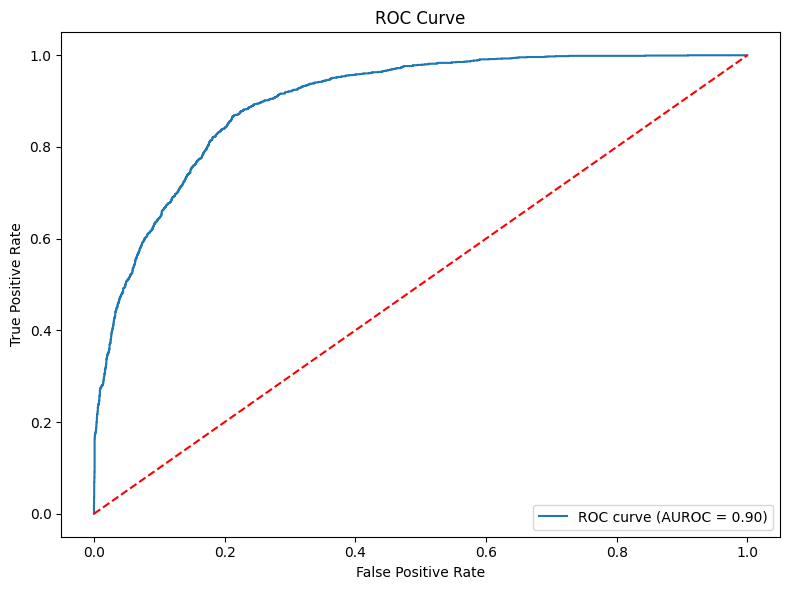

In [57]:
#ROC Curve visualization

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUROC = {auroc_score:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
